In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
plt.rcParams.update({'font.size': 20})

In [6]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [7]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [8]:
def make_scatter_plot_with_regression_line_z(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_std, feature_mean = torch.std_mean(feature)
    feature_z = (feature - feature_mean)/feature_std

    feature_z_and_1 = torch.stack(  ( feature_z, torch.ones_like(feature_z) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_z_and_1, param_col)
    param_pred = torch.matmul(feature_z_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}z({feature_name})+{intercept:.3g}, R^2={r_squared:.3g}')
    
    feature_z_np = depytorch(feature_z)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_z_np, param_np, color='blue')
    ax.plot(feature_z_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name} (z-score)')
    ax.set_ylabel(f'{param_name}')

In [9]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.

    feature_and_1 = torch.stack(  ( feature, torch.ones_like(feature) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_and_1, param_col)
    param_pred = torch.matmul(feature_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}')
    
    feature_np = depytorch(feature)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_np, param_np, color='blue')
    ax.plot(feature_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel(f'{param_name}')

In [10]:
def get_correlation_and_p(feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str, num_perms:int=1000000):
    # We assume both Tensors are 1D and the same size.
    
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    num_greater = 0
    num_values = feature.numel()
    corr_abs = corr.abs()
    for _ in range(num_perms):
        perm = torch.randperm( n=num_values, dtype=int_type, device=feature.device )
        perm_corr_abs = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature[perm], dim=0).abs()
        num_greater += (perm_corr_abs >= corr_abs)
    p_value = num_greater/num_perms
    
    print(f'{param_name} v. {feature_name} corr.={corr:.3g}, p-value={p_value:.3g}')
    return corr, p_value

In [11]:
num_beta = 101
min_beta = 1e-10
max_beta = 0.05
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
red_thresh = get_closest_match(values=threshold, target=1.6)
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8_param_updates_40000'
# param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8_param_updates_63000'

In [12]:
base_color_amplitude = 1.0
red_cval = [base_color_amplitude, 0.0, 0.0]
orange_cval = [base_color_amplitude, base_color_amplitude*0.5, 0.0]
green_cval = [0.0, base_color_amplitude, 0.0]
blue_cval = [0.0, 0.0, base_color_amplitude]

In [12]:
rmse_h_group_train = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_1000000_batchsz_-1_lr_0.001_nodewise_group_h_mean_all_train_group_thresholds_31_min_0_max_3_63k.pt'), weights_only=False )
print( rmse_h_group_train.size() )

torch.Size([3, 1000000, 31])


In [13]:
rmse_h_group_test = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_1000000_batchsz_-1_lr_0.001_nodewise_group_h_mean_all_test_group_thresholds_31_min_0_max_3_63k.pt'), weights_only=False )
print( rmse_h_group_test.size() )

torch.Size([3, 1000000, 31])


In [22]:
rmse_h_group_train = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_1000_batchsz_-1_lr_0.1_nodewise_group_h_mean_all_train_group_thresholds_31_min_0_max_3_63k.pt'), weights_only=False )
print( rmse_h_group_train.size() )

torch.Size([3, 1000, 31])


In [23]:
rmse_h_group_test = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_1000_batchsz_-1_lr_0.1_nodewise_group_h_mean_all_test_group_thresholds_31_min_0_max_3_63k.pt'), weights_only=False )
print( rmse_h_group_test.size() )

torch.Size([3, 1000, 31])


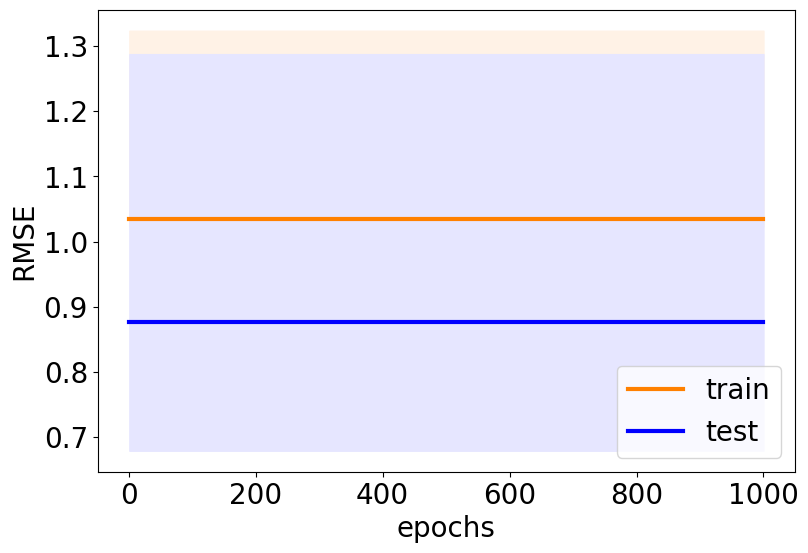

In [24]:
# num_steps = min( fc_corr_series_init_means.size(dim=0), fc_corr_series_init_normal.size(dim=0) )
steps_to_plot = 1000
step_increment = 1
num_steps = rmse_h_group_train.size(dim=1)
step_count_np = depytorch(  torch.arange( start=step_increment, end=step_increment*(num_steps+1), step=step_increment, dtype=torch.float, device=device )  )
line_width = 3.0
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
for fc_corr_series, summary_name, summary_cval in zip([rmse_h_group_train, rmse_h_group_test],['train', 'test'],[orange_cval, blue_cval]):
    fc_corr_series_flat = fc_corr_series[:,:,threshold_index]
    fc_corr_median = depytorch( torch.median(fc_corr_series_flat,dim=0).values )
    fc_corr_min = depytorch( torch.min(fc_corr_series_flat,dim=0).values )
    fc_corr_max = depytorch( torch.max(fc_corr_series_flat,dim=0).values )
    axs.fill_between( step_count_np[:steps_to_plot], fc_corr_min[:steps_to_plot], fc_corr_max[:steps_to_plot], color=[0.9+0.1*c for c in summary_cval])# , label=f'thresh.={selected_threshold:.3g} range'
    axs.plot( step_count_np[:steps_to_plot], fc_corr_median[:steps_to_plot], color=summary_cval, linewidth=line_width, label=summary_name )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend(loc='lower right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('epochs')
axs.set_ylabel('RMSE')
plt.show()

In [25]:
print('final RMSE')
print( 'train', rmse_h_group_train[:,-1,threshold_index].tolist() )
print( 'test', rmse_h_group_test[:,-1,threshold_index].tolist() )

final RMSE
train [1.323561191558838, 1.0231525897979736, 1.0343877077102661]
test [1.2875943183898926, 0.6788421273231506, 0.8771356344223022]


In [30]:
rmse_h_group_train = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_1000_batchsz_-1_lr_0.1_subjectwise_h_all_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt'), weights_only=False )
print( rmse_h_group_train.size() )

torch.Size([3, 1000, 360])


In [32]:
rmse_example_series = rmse_h_group_train[0,:,0]
print( rmse_example_series.min().item(), rmse_example_series.max().item() )

1.3139851093292236 1.3139851093292236


In [31]:
rmse_h_group_test = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_1000_batchsz_-1_lr_0.1_subjectwise_h_all_test_subjectwise_-310_perms_3_individual_from_group_glasser_1_50k_progress.pt'), weights_only=False )
print( rmse_h_group_test.size() )

torch.Size([3, 1000, 360])


In [60]:
def load_big_fitting_progress_summary_group(file_str:str):
    fit = torch.load( f=os.path.join(file_dir, file_str), weights_only=False ).transpose(dim0=0, dim1=2)
    print( fit.size() )
    return fit.min(dim=-1).values, fit.median(dim=-1).values, fit.max(dim=-1).values

In [61]:
rmse_h_group_train_min, rmse_h_group_train_median, rmse_h_group_train_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_nodewise_group_h_mean_all_train_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_h_group_train_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [62]:
rmse_h_group_test_min, rmse_h_group_test_median, rmse_h_group_test_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_nodewise_group_h_mean_all_test_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_h_group_test_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [149]:
rmse_h_group_train_min, rmse_h_group_train_median, rmse_h_group_train_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_nodewise_group_h_mean_all_train_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_h_group_train_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [148]:
rmse_h_group_test_min, rmse_h_group_test_median, rmse_h_group_test_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_nodewise_group_h_mean_all_test_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_h_group_test_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [191]:
rmse_h_group_train_min, rmse_h_group_train_median, rmse_h_group_train_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_nodewise_group_h_mean_all_train_group_thresholds_31_min_0_max_3_63k_v2.pt')
print( rmse_h_group_train_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [192]:
rmse_h_group_test_min, rmse_h_group_test_median, rmse_h_group_test_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_nodewise_group_h_mean_all_test_group_thresholds_31_min_0_max_3_63k_v2.pt')
print( rmse_h_group_test_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


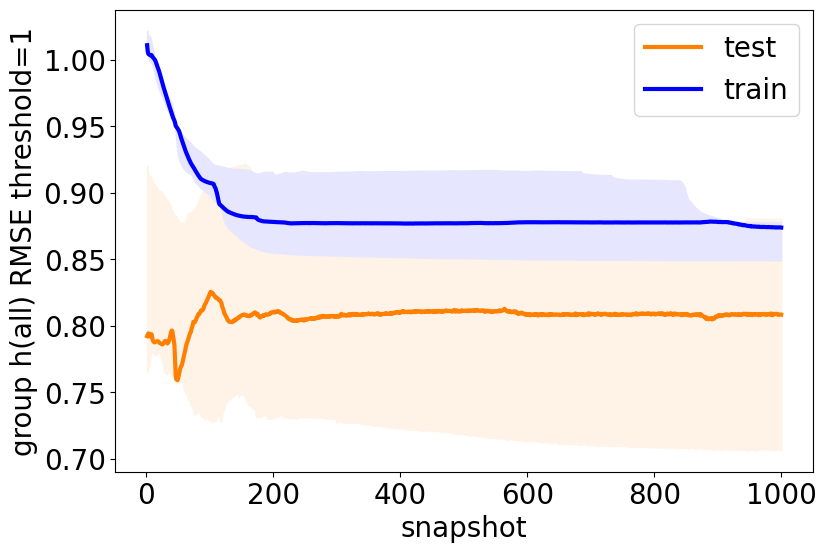

In [193]:
# num_steps = min( fc_corr_series_init_means.size(dim=0), fc_corr_series_init_normal.size(dim=0) )
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
steps_to_plot = 1000
step_increment = 1
num_steps = rmse_h_group_train_median.size(dim=-1)
step_count_np = depytorch(  torch.arange( start=step_increment, end=step_increment*(num_steps+1), step=step_increment, dtype=torch.float, device=device )  )
line_width = 3.0
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_h_group_test_min[threshold_index,:steps_to_plot]), depytorch(rmse_h_group_test_max[threshold_index,:steps_to_plot]), color=[0.9+0.1*c for c in orange_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_h_group_test_median[threshold_index,:steps_to_plot]), color=orange_cval, linewidth=line_width, label='test' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_h_group_train_min[threshold_index,:steps_to_plot]), depytorch(rmse_h_group_train_max[threshold_index,:steps_to_plot]), color=[0.9+0.1*c for c in blue_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_h_group_train_median[threshold_index,:steps_to_plot]), color=blue_cval, linewidth=line_width, label='train' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('snapshot')
axs.set_ylabel(f'group h(all) RMSE threshold={selected_threshold:.3g}')
plt.show()

In [194]:
print(f'h group final Adam RMSE for threshold {selected_threshold:.3g}')
print( 'train', rmse_h_group_train_min[threshold_index,-1].item(), rmse_h_group_train_median[threshold_index,-1].item(), rmse_h_group_train_max[threshold_index,-1].item() )
print( 'test', rmse_h_group_test_min[threshold_index,-1].item(), rmse_h_group_test_median[threshold_index,-1].item(), rmse_h_group_test_max[threshold_index,-1].item() )

h group final Adam RMSE for threshold 1
train 0.8492132425308228 0.8738948106765747 0.8779811859130859
test 0.7066985368728638 0.8084162473678589 0.8796598315238953


In [126]:
rmse_h_group_train_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_nodewise_group_h_mean_node_features_train_group_thresholds_31_min_0_max_3_63k_v4.pt'), weights_only=False )
print( rmse_h_group_train_lstsq.size() )

torch.Size([31, 1000000])


In [127]:
rmse_h_group_test_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_nodewise_group_h_mean_node_features_test_group_thresholds_31_min_0_max_3_63k_v4.pt'), weights_only=False )
print( rmse_h_group_train_lstsq.size() )

torch.Size([31, 1000000])


In [128]:
print(f'h group least squares RMSE for threshold {selected_threshold:.3g}')
print( 'train', rmse_h_group_train_lstsq[threshold_index,:].min().item(), rmse_h_group_train_lstsq[threshold_index,:].median().item(), rmse_h_group_train_lstsq[threshold_index,:].max().item() )
print( 'test', rmse_h_group_test_lstsq[threshold_index,:].min().item(), rmse_h_group_test_lstsq[threshold_index,:].median().item(), rmse_h_group_test_lstsq[threshold_index,:].max().item() )

h group least squares RMSE for threshold 1
train 0.9110601544380188 0.9563403129577637 0.9848529696464539
test 0.5664941668510437 0.9661415219306946 1.6488295793533325


In [65]:
rmse_J_group_train_min, rmse_J_group_train_median, rmse_J_group_train_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_pairwise_group_J_mean_sc_train_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_J_group_train_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [66]:
rmse_J_group_test_min, rmse_J_group_test_median, rmse_J_group_test_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_pairwise_group_J_mean_sc_test_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_J_group_test_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [156]:
rmse_J_group_train_min, rmse_J_group_train_median, rmse_J_group_train_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_pairwise_group_J_mean_sc_train_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_J_group_train_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [157]:
rmse_J_group_test_min, rmse_J_group_test_median, rmse_J_group_test_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_pairwise_group_J_mean_sc_test_group_thresholds_31_min_0_max_3_63k.pt')
print( rmse_J_group_test_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [195]:
rmse_J_group_train_min, rmse_J_group_train_median, rmse_J_group_train_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_pairwise_group_J_mean_sc_train_group_thresholds_31_min_0_max_3_63k_v2.pt')
print( rmse_J_group_train_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


In [196]:
rmse_J_group_test_min, rmse_J_group_test_median, rmse_J_group_test_max = load_big_fitting_progress_summary_group('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_pairwise_group_J_mean_sc_test_group_thresholds_31_min_0_max_3_63k_v2.pt')
print( rmse_J_group_test_median.size() )

torch.Size([31, 1000, 3])
torch.Size([31, 1000])


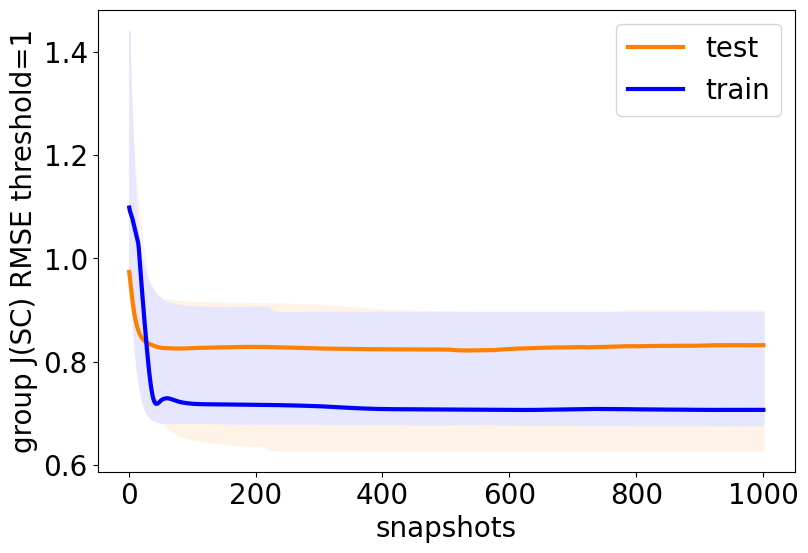

In [197]:
# num_steps = min( fc_corr_series_init_means.size(dim=0), fc_corr_series_init_normal.size(dim=0) )
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
steps_to_plot = 1000
step_increment = 1
num_steps = rmse_h_group_train_median.size(dim=-1)
step_count_np = depytorch(  torch.arange( start=step_increment, end=step_increment*(num_steps+1), step=step_increment, dtype=torch.float, device=device )  )
line_width = 3.0
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_J_group_test_min[threshold_index,:steps_to_plot]), depytorch(rmse_J_group_test_max[threshold_index,:steps_to_plot]), color=[0.9+0.1*c for c in orange_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_J_group_test_median[threshold_index,:steps_to_plot]), color=orange_cval, linewidth=line_width, label='test' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_J_group_train_min[threshold_index,:steps_to_plot]), depytorch(rmse_J_group_train_max[threshold_index,:steps_to_plot]), color=[0.9+0.1*c for c in blue_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_J_group_train_median[threshold_index,:steps_to_plot]), color=blue_cval, linewidth=line_width, label='train' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('snapshots')
axs.set_ylabel(f'group J(SC) RMSE threshold={selected_threshold:.3g}')
plt.show()

In [198]:
print(f'J group final Adam RMSE for threshold {selected_threshold:.3g}')
print( 'train', rmse_J_group_train_min[threshold_index,-1].item(), rmse_J_group_train_median[threshold_index,-1].item(), rmse_J_group_train_max[threshold_index,-1].item() )
print( 'test', rmse_J_group_test_min[threshold_index,-1].item(), rmse_J_group_test_median[threshold_index,-1].item(), rmse_J_group_test_max[threshold_index,-1].item() )

J group final Adam RMSE for threshold 1
train 0.6772782206535339 0.707022488117218 0.8963647484779358
test 0.6284182667732239 0.8322340846061707 0.8990168571472168


In [129]:
rmse_J_group_train_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_pairwise_group_J_mean_SC_train_group_thresholds_31_min_0_max_3_63k_v3.pt'), weights_only=False )
print( rmse_J_group_train_lstsq.size() )

torch.Size([31, 1000])


In [130]:
rmse_J_group_test_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_pairwise_group_J_mean_SC_test_group_thresholds_31_min_0_max_3_63k_v3.pt'), weights_only=False )
print( rmse_J_group_test_lstsq.size() )

torch.Size([31, 1000])


In [131]:
print(f'J group least squares RMSE for threshold {selected_threshold:.3g}')
print( 'train', rmse_J_group_train_lstsq[threshold_index,:].min().item(), rmse_J_group_train_lstsq[threshold_index,:].median().item(), rmse_J_group_train_lstsq[threshold_index,:].max().item() )
print( 'test', rmse_J_group_test_lstsq[threshold_index,:].min().item(), rmse_J_group_test_lstsq[threshold_index,:].median().item(), rmse_J_group_test_lstsq[threshold_index,:].max().item() )

J group least squares RMSE for threshold 1
train 0.5706910490989685 0.8401793837547302 0.9937146902084351
test 0.595633864402771 0.8757397532463074 2.802100896835327


In [54]:
def load_big_fitting_progress_summary_individual(file_str:str):
    fit = torch.load( f=os.path.join(file_dir, file_str), weights_only=False ).transpose(dim0=0, dim1=1).flatten(start_dim=1, end_dim=2)
    return fit.min(dim=-1).values, fit.median(dim=-1).values, fit.max(dim=-1).values

In [14]:
rmse_h_individual_train_min, rmse_h_individual_train_median, rmse_h_individual_train_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_1000000_batchsz_-1_lr_0.001_subjectwise_h_all_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_h_individual_train_median.size() )

torch.Size([1000000])


In [15]:
rmse_h_individual_test_min, rmse_h_individual_test_median, rmse_h_individual_test_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_1000000_batchsz_-1_lr_0.001_subjectwise_h_all_test_subjectwise_-310_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( mse_h_individual_test_median.size() )

torch.Size([1000000])


In [55]:
rmse_h_individual_train_min, rmse_h_individual_train_median, rmse_h_individual_train_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_subjectwise_h_all_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_h_individual_train_median.size() )

torch.Size([1000])


In [56]:
rmse_h_individual_test_min, rmse_h_individual_test_median, rmse_h_individual_test_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_subjectwise_h_all_test_subjectwise_-310_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_h_individual_test_median.size() )

torch.Size([1000])


In [161]:
rmse_h_individual_train_min, rmse_h_individual_train_median, rmse_h_individual_train_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_h_individual_train_median.size() )

torch.Size([1000])


In [162]:
rmse_h_individual_test_min, rmse_h_individual_test_median, rmse_h_individual_test_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_h_individual_test_median.size() )

torch.Size([1000])


In [199]:
rmse_h_individual_train_min, rmse_h_individual_train_median, rmse_h_individual_train_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt')
print( rmse_h_individual_train_median.size() )

torch.Size([1000])


In [200]:
rmse_h_individual_test_min, rmse_h_individual_test_median, rmse_h_individual_test_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt')
print( rmse_h_individual_test_median.size() )

torch.Size([1000])


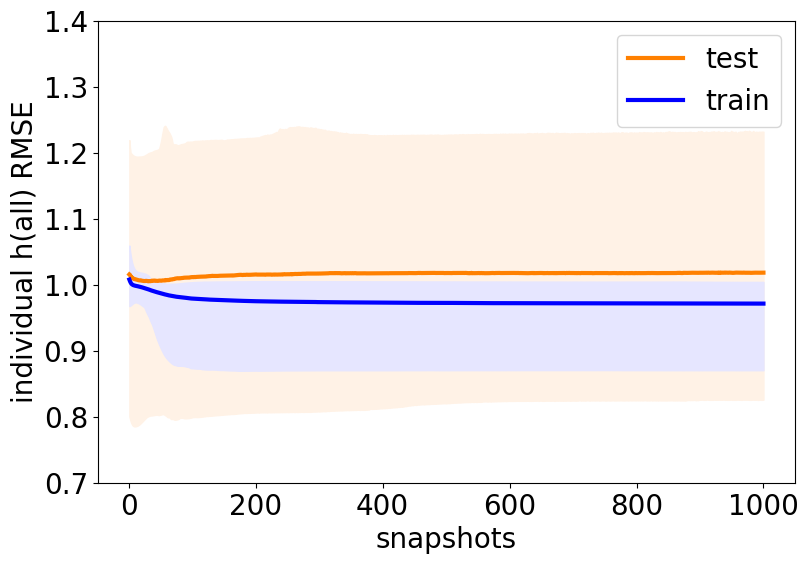

In [201]:
# num_steps = min( fc_corr_series_init_means.size(dim=0), fc_corr_series_init_normal.size(dim=0) )
steps_to_plot = 1000
step_increment = 1
num_steps = rmse_h_individual_train_median.size(dim=-1)
step_count_np = depytorch(  torch.arange( start=step_increment, end=step_increment*(num_steps+1), step=step_increment, dtype=torch.float, device=device )  )
line_width = 3.0
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_h_individual_test_min[:steps_to_plot]), depytorch(rmse_h_individual_test_max[:steps_to_plot]), color=[0.9+0.1*c for c in orange_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_h_individual_test_median[:steps_to_plot]), color=orange_cval, linewidth=line_width, label='test' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_h_individual_train_min[:steps_to_plot]), depytorch(rmse_h_individual_train_max[:steps_to_plot]), color=[0.9+0.1*c for c in blue_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_h_individual_train_median[:steps_to_plot]), color=blue_cval, linewidth=line_width, label='train' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_ylim([0.7, 1.4])
axs.set_xlabel('snapshots')
axs.set_ylabel('individual h(all) RMSE')
plt.show()

In [202]:
print('h individual final Adam RMSE')
print( 'train', rmse_h_individual_train_min[-1].item(), rmse_h_individual_train_median[-1].item(), rmse_h_individual_train_max[-1].item() )
print( 'test', rmse_h_individual_test_min[-1].item(), rmse_h_individual_test_median[-1].item(), rmse_h_individual_test_max[-1].item() )

h individual final Adam RMSE
train 0.8704710006713867 0.9713903069496155 1.0042321681976318
test 0.8257305026054382 1.01827871799469 1.2319015264511108


In [132]:
rmse_h_individual_train_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_subjectwise_h_node_features_train_subj_670_perms_10000_individual_from_group_glasser_1_50k_v2.pt'), weights_only=False )
print( rmse_h_individual_train_lstsq.size() )

torch.Size([360, 10000])


In [133]:
rmse_h_individual_test_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_subjectwise_h_node_features_test_subj_167_perms_10000_individual_from_group_glasser_1_50k_v2.pt'), weights_only=False )
print( rmse_h_individual_test_lstsq.size() )

torch.Size([360, 10000])


In [136]:
print('lstsq individual h(all) RMSE')
print( 'train', rmse_h_individual_train_lstsq.min().item(), rmse_h_individual_train_lstsq.median().item(), rmse_h_individual_train_lstsq.max().item() )
print( 'test', rmse_h_individual_test_lstsq.min().item(), rmse_h_individual_test_lstsq.median().item(), rmse_h_individual_test_lstsq.max().item() )

lstsq individual h(all) RMSE
train 0.8588399291038513 0.9907412528991699 0.9992493391036987
test 0.6931623220443726 0.9934839606285095 1.4699748754501343


In [68]:
rmse_J_individual_train_min, rmse_J_individual_train_median, rmse_J_individual_train_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_subjectwise_J_sc_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_J_individual_train_median.size() )

torch.Size([1000])


In [72]:
rmse_J_individual_test_min, rmse_J_individual_test_median, rmse_J_individual_test_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_1000_batchsz_-1_lr_0.1_subjectwise_J_sc_test_subjectwise_63950_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_J_individual_test_median.size() )

torch.Size([1000])


In [165]:
rmse_J_individual_train_min, rmse_J_individual_train_median, rmse_J_individual_train_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_J_individual_train_median.size() )

torch.Size([1000])


In [166]:
rmse_J_individual_test_min, rmse_J_individual_test_median, rmse_J_individual_test_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress.pt')
print( rmse_J_individual_test_median.size() )

torch.Size([1000])


In [203]:
rmse_J_individual_train_min, rmse_J_individual_train_median, rmse_J_individual_train_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt')
print( rmse_J_individual_train_median.size() )

torch.Size([1000])


In [204]:
rmse_J_individual_test_min, rmse_J_individual_test_median, rmse_J_individual_test_max = load_big_fitting_progress_summary_individual('rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt')
print( rmse_J_individual_test_median.size() )

torch.Size([1000])


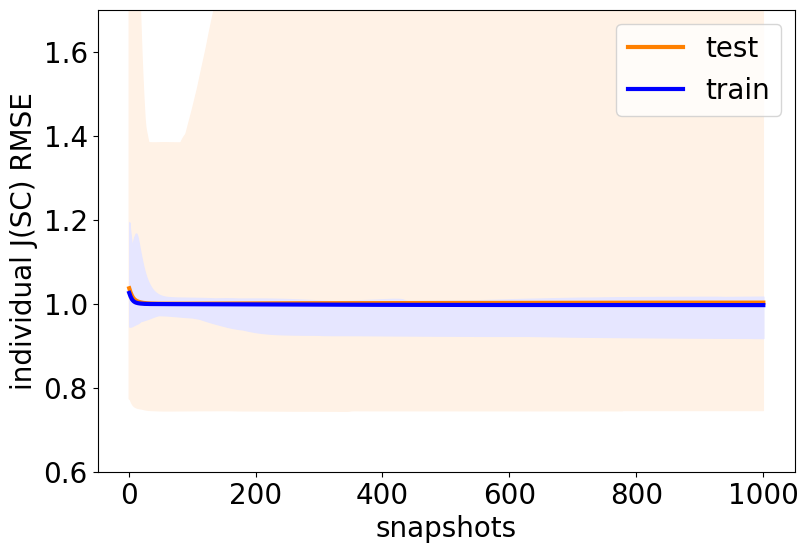

In [205]:
# num_steps = min( fc_corr_series_init_means.size(dim=0), fc_corr_series_init_normal.size(dim=0) )
steps_to_plot = 1000
step_increment = 1
num_steps = rmse_h_individual_train_median.size(dim=-1)
step_count_np = depytorch(  torch.arange( start=step_increment, end=step_increment*(num_steps+1), step=step_increment, dtype=torch.float, device=device )  )
line_width = 3.0
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_J_individual_test_min[:steps_to_plot]), depytorch(rmse_J_individual_test_max[:steps_to_plot]), color=[0.9+0.1*c for c in orange_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_J_individual_test_median[:steps_to_plot]), color=orange_cval, linewidth=line_width, label='test' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.fill_between( step_count_np[:steps_to_plot], depytorch(rmse_J_individual_train_min[:steps_to_plot]), depytorch(rmse_J_individual_train_max[:steps_to_plot]), color=[0.9+0.1*c for c in blue_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np[:steps_to_plot], depytorch(rmse_J_individual_train_median[:steps_to_plot]), color=blue_cval, linewidth=line_width, label='train' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_ylim([0.6, 1.7])
axs.set_xlabel('snapshots')
axs.set_ylabel('individual J(SC) RMSE')
plt.show()

In [206]:
print('J individual final RMSE')
print( 'train', rmse_J_individual_train_min[-1].item(), rmse_J_individual_train_median[-1].item(), rmse_J_individual_train_max[-1].item() )
print( 'test', rmse_J_individual_test_min[-1].item(), rmse_J_individual_test_median[-1].item(), rmse_J_individual_test_max[-1].item() )

J individual final RMSE
train 0.9183038473129272 0.9967002272605896 1.016784906387329
test 0.7457873821258545 1.0026081800460815 2.615722894668579


In [142]:
rmse_J_individual_train_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_subjectwise_J_SC_train_subj_670_perms_1000_individual_from_group_glasser_1_50k.pt'), weights_only=False )
print( rmse_J_individual_train_lstsq.size() )

torch.Size([64620, 1000])


In [143]:
rmse_J_individual_test_lstsq = torch.load( f=os.path.join(file_dir, 'lstsq_rmse_subjectwise_J_SC_test_subj_167_perms_1000_individual_from_group_glasser_1_50k.pt'), weights_only=False )
print( rmse_J_individual_test_lstsq.size() )

torch.Size([64620, 1000])


In [146]:
print('lstsq individual J(SC) RMSE')
print( 'train', rmse_J_individual_train_lstsq.min().item(), rmse_J_individual_train_lstsq.median().item(), rmse_J_individual_train_lstsq.max().item() )
print( 'test', rmse_J_individual_test_lstsq.min().item(), rmse_J_individual_test_lstsq.median().item(), rmse_J_individual_test_lstsq.max().item() )

lstsq individual J(SC) RMSE
train 0.8925760984420776 0.9988564848899841 0.9992536306381226
test 0.6582046747207642 0.9995724558830261 3.032006025314331


In [208]:
rmse_h_individual_train_adam = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_h_individual_train_adam.size() )

torch.Size([1000, 3, 360])


In [209]:
rmse_h_individual_test_adam = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_h_individual_test_adam.size() )

torch.Size([1000, 3, 360])


In [210]:
rmse_h_individual_train_adam_stacked = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_h_individual_train_adam_stacked.size() )

torch.Size([1000, 3, 360])


In [211]:
rmse_h_individual_test_adam_stacked = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_h_all_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_h_individual_test_adam_stacked.size() )

torch.Size([1000, 3, 360])


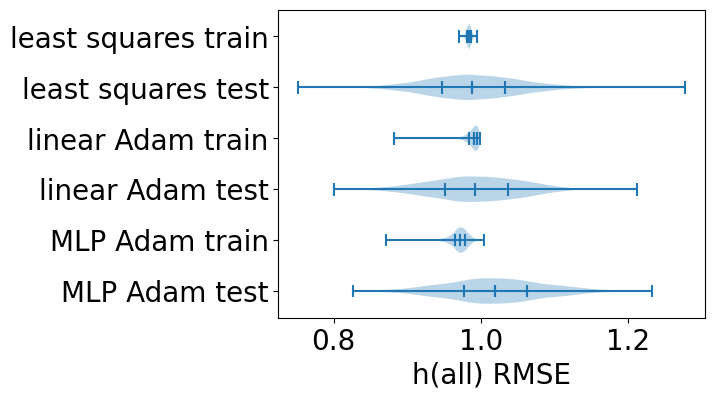

In [220]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['least squares train', 'least squares test', 'linear Adam train', 'linear Adam test', 'MLP Adam train', 'MLP Adam test']
label_x = range( 1, len(corr_labels)+1 )
all_rmses = [ depytorch( rmse_tensor[-1].flatten() ) for rmse_tensor in [rmse_h_individual_train_lstsq, rmse_h_individual_test_lstsq, rmse_h_individual_train_adam, rmse_h_individual_test_adam, rmse_h_individual_train_adam_stacked, rmse_h_individual_test_adam_stacked] ]
axs.violinplot(  list( reversed(all_rmses) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rmses), orientation='horizontal'  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('h(all) RMSE')
plt.show()

In [215]:
rmse_J_individual_train_adam = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_J_individual_train_adam.size() )

torch.Size([1000, 3, 64620])


In [216]:
rmse_J_individual_test_adam = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_J_individual_test_adam.size() )

torch.Size([1000, 3, 64620])


In [217]:
rmse_J_individual_train_adam_stacked = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_train_subjectwise_670_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_J_individual_train_adam_stacked.size() )

torch.Size([1000, 3, 64620])


In [218]:
rmse_J_individual_test_adam_stacked = torch.load( f=os.path.join(file_dir, 'rmse_adam_epochs_10000_batchsz_-1_lr_0.001_max_snapshots_1000_subjectwise_J_sc_test_subjectwise_167_perms_3_individual_from_group_glasser_1_50k_progress_v2.pt'), weights_only=False ).transpose(dim0=0, dim1=1)
print( rmse_J_individual_test_adam_stacked.size() )

torch.Size([1000, 3, 64620])


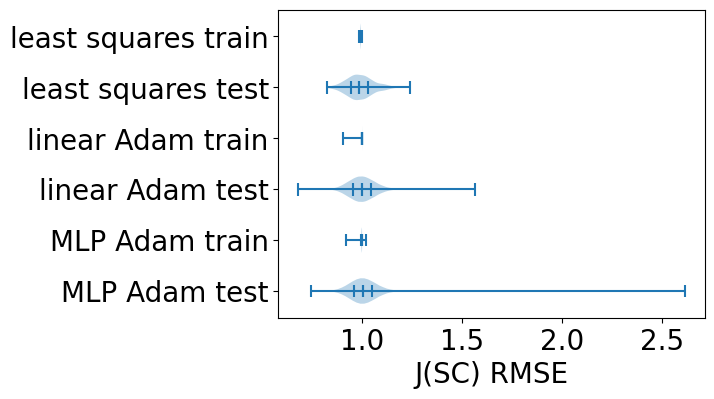

In [221]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['least squares train', 'least squares test', 'linear Adam train', 'linear Adam test', 'MLP Adam train', 'MLP Adam test']
label_x = range( 1, len(corr_labels)+1 )
all_rmses = [ depytorch( rmse_tensor[-1].flatten() ) for rmse_tensor in [rmse_J_individual_train_lstsq, rmse_J_individual_test_lstsq, rmse_J_individual_train_adam, rmse_J_individual_test_adam, rmse_J_individual_train_adam_stacked, rmse_J_individual_test_adam_stacked] ]
axs.violinplot(  list( reversed(all_rmses) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rmses), orientation='horizontal'  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('J(SC) RMSE')
plt.show()

In [4]:
fc_corr = torch.load( f=os.path.join(other_file_dir, 'fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_63000_test_length_120000.pt'), weights_only=False )
print( fc_corr.size() )

torch.Size([101, 31])


In [5]:
threshold_index = 10
fc_corr_at_threshold = fc_corr[:,threshold_index]
best_rep_index = torch.argmax(fc_corr_at_threshold)
best_fc_corr = fc_corr_at_threshold[best_rep_index]
print( best_rep_index, best_fc_corr.item() )

tensor(89, device='cuda:0') 0.9936282634735107


In [7]:
print( fc_corr_at_threshold.min().item(), fc_corr_at_threshold.max().item() )

0.9762640595436096 0.9936282634735107
